# Detecting AI-Generated Content on HC3 Dataset
### This notebook is to train and evaluate roberta-base model on HC3 Dataset

# Install Necessary Libraries

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 298.1 kB/s eta 0:00:00


# Import Libraries

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
import pandas as pd
import evaluate

# Data Preprocessing

In [4]:
# Step 1: Model and Tokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id

# Step 2: Load Dataset
ds = load_dataset("Hello-SimpleAI/HC3", "all")

def process_example(example):
    human_samples = [{"text": ans, "label": 0} for ans in example['human_answers']]
    chatgpt_samples = [{"text": ans, "label": 1} for ans in example['chatgpt_answers']]
    return {"human": human_samples, "chatgpt": chatgpt_samples}

processed = ds["train"].map(process_example, remove_columns=ds["train"].column_names)

all_samples = []
for row in processed:
    all_samples.extend(row["human"])
    all_samples.extend(row["chatgpt"])

data_df = pd.DataFrame(all_samples)
dataset = Dataset.from_pandas(data_df)

# Step 3: Split Dataset into Train and Validation
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]

# Step 4: Tokenize Dataset
def tokenize_fn(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)

# Remove unnecessary columns
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])

# Convert to PyTorch format
train_dataset = train_dataset.with_format("torch")
val_dataset = val_dataset.with_format("torch")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

HC3.py:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/39.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

Map:   0%|          | 0/24322 [00:00<?, ? examples/s]

Map:   0%|          | 0/68359 [00:00<?, ? examples/s]

Map:   0%|          | 0/17090 [00:00<?, ? examples/s]

# Define Metrics for Evaluation

In [5]:
# Step 5: Metrics for Evaluation
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy_metric.compute(predictions=predictions.numpy(), references=labels)

# Set Training Arguments

In [6]:
# Step 6: Training Arguments
training_args = TrainingArguments(
    output_dir="./outputs",
    evaluation_strategy="epoch",  # Evaluate after each epoch
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=1000,
    save_total_limit=1,
    learning_rate=1e-5,
    weight_decay=0.01,
    report_to="none",
    disable_tqdm=False,
    fp16=True
)

# Step 7: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-a9dd4a58efb3>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Train Model

In [7]:
# Step 8: Train Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.000000,0.014937,0.998128
2,0.000000,0.006907,0.999005
3,0.000000,0.013853,0.998537


TrainOutput(global_step=51270, training_loss=0.01227409101247121, metrics={'train_runtime': 5684.1444, 'train_samples_per_second': 36.079, 'train_steps_per_second': 9.02, 'total_flos': 1.348950647501568e+16, 'train_loss': 0.01227409101247121, 'epoch': 3.0})

In [8]:
trainer.save_model("./finetuned_model")

# Evaluate and Visualize Result

# Loss Plot

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_accuracy', 'eval_runtime', 'eval_samples_per_second',
       'eval_steps_per_second', 'train_runtime', 'train_samples_per_second',
       'train_steps_per_second', 'total_flos', 'train_loss'],
      dtype='object')


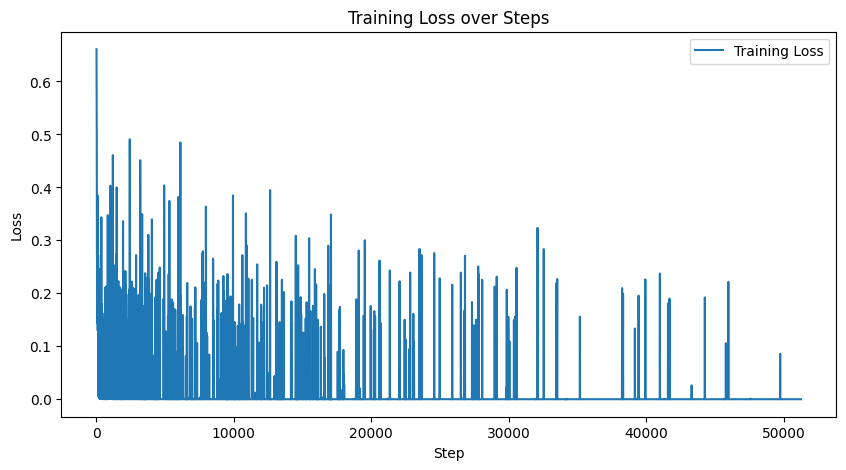

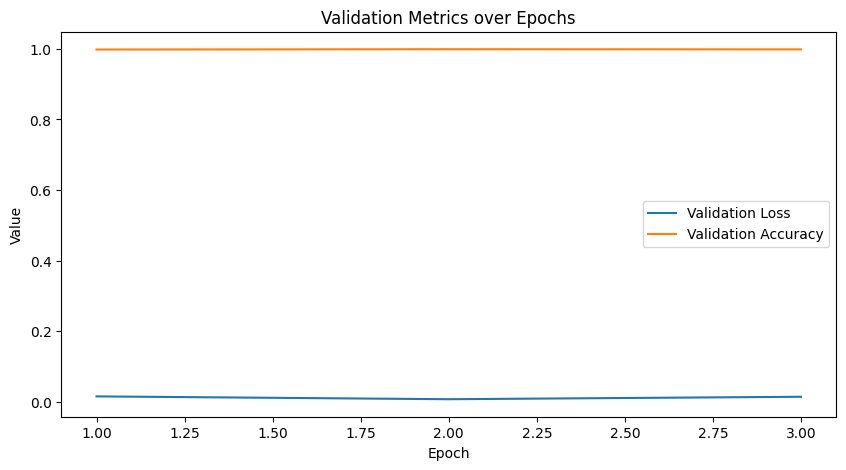

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert log to DataFrame
logs = pd.DataFrame(trainer.state.log_history)

# Print log columns to see what metrics are included
print(logs.columns)

# Assuming logs contain 'loss', 'eval_loss', 'eval_accuracy' etc.
# Plot training loss curve (over global_step)
plt.figure(figsize=(10,5))
plt.plot(logs["step"], logs["loss"], label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.show()

# If logs contain eval_accuracy and eval_loss at the end of each epoch, plot by epoch
eval_logs = logs.dropna(subset=["eval_loss"])
plt.figure(figsize=(10,5))
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Validation Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Validation Metrics over Epochs")
plt.legend()
plt.show()

# Confusion Matrix

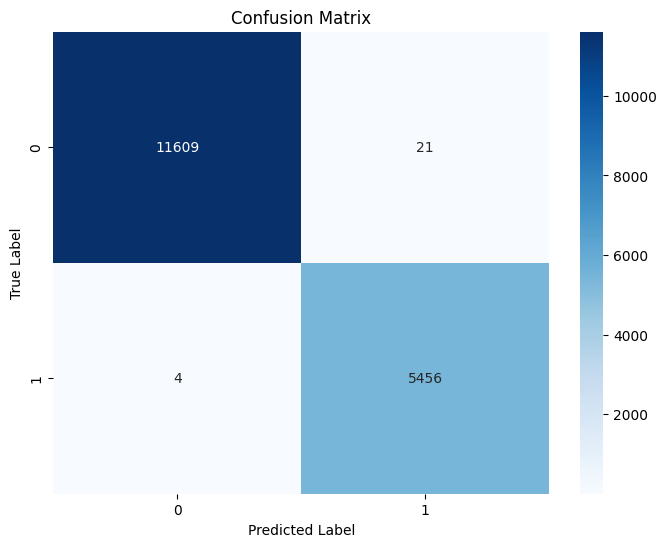

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make prediction
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

# Draw Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Generate Classification Report

In [14]:
from sklearn.metrics import classification_report

# Define labels
labels = ["Human", "ChatGPT"]

# Generate classification report
report = classification_report(true_labels, pred_labels, target_names=labels)
print(report)

              precision    recall  f1-score   support

       Human       1.00      1.00      1.00     11630
     ChatGPT       1.00      1.00      1.00      5460

    accuracy                           1.00     17090
   macro avg       1.00      1.00      1.00     17090
weighted avg       1.00      1.00      1.00     17090



# Highlight for Human Text

In [30]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from IPython.core.display import display, HTML

# Load tokenizer and model
model_path = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForMaskedLM.from_pretrained(model_path)

# Input text (Ensure it's not excessively long)
text = ("The Common Core is a series of optional standards suggested for determining school curricula . 45 states have adopted it . The standards for math and English are [ summarized here ] ( URL_0 ) if you want to read about it in more detail . The idea is to make sure students are better prepared when they finish high school . In terms of content , it has some new ideas like an increased focus on reading non - fiction . There are also suggestions that fewer topics are covered , but each in more depth . A lot of time , effort , and research has gone into the Common Core , so many people favor it on the grounds that")

# Tokenize the text with truncation and padding enabled
encoded = tokenizer(text, return_tensors='pt', truncation=True, padding="max_length", max_length=512)
input_ids = encoded['input_ids'][0]

highlighted_text = ""

# Process each token in the text
for i, token_id in enumerate(input_ids):
    token_str = tokenizer.decode([token_id]).strip()
    # Skip special tokens
    if token_str in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token, ""]:
        highlighted_text += f"{token_str} "
        continue

    # Mask the current token
    masked_input_ids = input_ids.clone()
    masked_input_ids[i] = tokenizer.mask_token_id
    with torch.no_grad():
        outputs = model(masked_input_ids.unsqueeze(0))
    logits = outputs.logits[0, i, :]
    sorted_indices = torch.argsort(logits, descending=True)

    # Determine the rank of the original token
    rank = (sorted_indices == token_id).nonzero(as_tuple=True)[0].item() + 1

    # Assign color based on rank
    if rank <= 10:
        color = "#b7eb9b"  # Green
    elif rank <= 100:
        color = "#ffe58f"  # Yellow
    elif rank <= 1000:
        color = "#ffccc7"  # Red
    else:
        color = "#d3adf7"  # Purple

    # Add the token with color to the highlighted text
    highlighted_text += f'<span style="background-color:{color};padding:2px;">{token_str}</span> '

# Generate HTML for display
html_content = f"<p style='text-decoration:none;'>{highlighted_text.strip()}</p>"
display(HTML(html_content))


# Highlight for Chatgpt Text

In [36]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from IPython.core.display import display, HTML

# Step 1: Load tokenizer and model
model_path = 'roberta-base' 
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForMaskedLM.from_pretrained(model_path)

# Step 2: Input text (Ensure it's not excessively long)
text = ("The word credit can have a number of different meanings depending on the context in which it is used. Some common meanings of the word include:An arrangement in which a customer can receive goods or services now and pay for them later: When you make a purchase on credit, you are borrowing money from the lender (usually a bank or credit card company) to pay for the item or service, and you will be required to pay back the borrowed amount, plus any interest, at a later date.A sum of money that is owed to someone: If you have credit with a company or individual, it means that they owe")

# Tokenize the text with truncation and padding enabled
encoded = tokenizer(text, return_tensors='pt', truncation=True, padding="max_length", max_length=512)
input_ids = encoded['input_ids'][0]

highlighted_text = ""

# Step 3: Process each token in the text
for i, token_id in enumerate(input_ids):
    token_str = tokenizer.decode([token_id]).strip()
    # Skip special tokens
    if token_str in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token, ""]:
        highlighted_text += f"{token_str} "
        continue

    # Mask the current token
    masked_input_ids = input_ids.clone()
    masked_input_ids[i] = tokenizer.mask_token_id
    with torch.no_grad():
        outputs = model(masked_input_ids.unsqueeze(0))
    logits = outputs.logits[0, i, :]
    sorted_indices = torch.argsort(logits, descending=True)

    # Determine the rank of the original token
    rank = (sorted_indices == token_id).nonzero(as_tuple=True)[0].item() + 1

    # Assign color based on rank
    if rank <= 10:
        color = "#b7eb9b"  # Green
    elif rank <= 100:
        color = "#ffe58f"  # Yellow
    elif rank <= 1000:
        color = "#ffccc7"  # Red
    else:
        color = "#d3adf7"  # Purple

    # Add the token with color to the highlighted text
    highlighted_text += f'<span style="background-color:{color};padding:2px;">{token_str}</span> '

# Step 4: Generate HTML for display
html_content = f"<p style='text-decoration:none;'>{highlighted_text.strip()}</p>"
display(HTML(html_content))